# **Programa Especializado en Credit Scoring con Python**
<img src="../../figuras/logo.png" width="200"/>

## 📊 **Sesión 2: Datos Crediticios y Definición del Evento de Incumplimiento**

**Docente**: Enzo Infantes Zúñiga  
**Contacto**: <enzo.infantes28@gmail.com>  
**LinkedIn**: [enzo-infantes](https://www.linkedin.com/in/enzo-infantes/)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

absolute_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(absolute_path, "data", "s02")

np.random.seed(42)

## 🎯 **Objetivo**

En esta sesión vamos a entender:

- Qué tipo de datos existen en banca para credit scoring
- Cuáles son las fuentes típicas de información
- Qué variables se utilizan realmente
- Qué supuestos deben validarse antes de modelar
- Cómo definir correctamente el perímetro del modelo
- Cómo construir coherentemente el target

## Mensaje central

Antes de modelar, debemos entender:

1) Qué información tenemos  
2) Qué estamos intentando predecir  
3) Para qué se usará el modelo  

## 🗂️ **1. Tipos de Datos en Credit Scoring**

En banca, los datos suelen dividirse en cuatro grandes grupos:

### **1.1 Datos Demográficos**

- Edad
- Estado civil
- Nivel educativo
- Región
- Antigüedad laboral

Son variables relativamente estables.

### **1.2 Datos Financieros**

- Ingreso declarado
- Ingreso validado
- Nivel de endeudamiento
- Ratio cuota/ingreso
- Activos

Son variables estructurales de capacidad de pago.

### **1.3 Datos Comportamentales (Behavioral)**

- Historial de pagos
- DPD histórico
- Utilización de línea
- Número de productos
- Rotación de saldo

Son las variables más predictivas en modelos de comportamiento.

### **1.4 Datos de Buró / Externos**

- Score externo
- Deudas en otras entidades
- Morosidad externa
- Número de consultas

Permiten capturar riesgo sistémico del cliente.

### **1.5 Datos Macroeconómicos (en modelos PIT / IFRS9)**

- Desempleo
- Inflación
- PBI
- Tasa de interés

Se usan para ajustar PD al ciclo.

# 📄​ **2. Fuentes de Información en Banca**

Típicamente:

- Core bancario (créditos, pagos, saldos)
- Data warehouse
- Buró de crédito
- Información macroeconómica pública
- Modelos internos previos

⚠ Problema frecuente:
La información está distribuida en múltiples sistemas.

# 📚​ **3. Definición del Perímetro del Modelo**

Antes de modelar debemos definir:

- ¿Qué producto?
    - Tarjeta
    - Consumo
    - Hipotecario
- ¿Qué segmento?
    - Retail
    - Pyme
- ¿Qué tipo de modelo?
    - Originación
    - Comportamental
    - Preventivo

Ejemplo:

Modelo de originación consumo no revolvente,
clientes nuevos,
horizonte 12 meses,
default 90 DPD.

## ​🔎 **4. Supuestos y Consideraciones Previas**

Antes de modelar debemos validar:

1) Estabilidad histórica del default
2) Calidad de datos (missing, outliers)
3) Representatividad de la muestra
4) Ventanas bien alineadas
5) No leakage temporal
6) Homogeneidad del portafolio
7) Suficiente volumen de defaults

## 📌 **5. Definición del Target**

El target debe definir claramente:

- Evento (ej. 90 DPD)
- Horizonte (ej. 12 meses)
- Unidad de análisis (cliente u operación)

Formalmente:

- $Y_i = 1$ si el cliente entra en default dentro de 12 meses
- $Y_i = 0$ en caso contrario

La calidad del modelo depende directamente de la calidad del target.


In [8]:
n = 10000  # Tamaño de muestra suficientemente grande para simular una cartera realista

# ==============================
# 1. GENERACIÓN DE VARIABLES
# ==============================

# Variables demográficas
# Edad distribuida normalmente alrededor de 40 años (cliente típico retail)
edad = np.random.normal(40, 10, n)

# Ingreso mensual promedio 3500 con desviación razonable
# Refleja heterogeneidad económica en la cartera
ingreso = np.random.normal(3500, 800, n)


# Variables financieras
# Ratio deuda entre 10% y 80%
# En la práctica bancaria este indicador es uno de los más relevantes
ratio_deuda = np.random.uniform(0.1, 0.8, n)


# Variables comportamentales
# Utilización de línea de crédito entre 10% y 100%
# Alta utilización suele asociarse a mayor estrés financiero
utilizacion = np.random.uniform(0.1, 1.0, n)

# Historial de días de mora
# Se asignan probabilidades realistas: la mayoría sin mora
dpd_hist = np.random.choice(
    [0, 30, 60, 90],
    n,
    p=[0.75, 0.12, 0.08, 0.05]
)


# ==============================
# 2. CONSTRUCCIÓN DEL RIESGO LATENTE
# ==============================

# Usamos una estructura logística porque:
# - El default es binario (0/1)
# - La función logística asegura probabilidades entre 0 y 1
# - Es el modelo estándar en credit scoring

logit = (
    -4
    # Intercepto:
    # Define un nivel base de riesgo bajo (~2%).
    # Representa una cartera sana si todas las variables están en valores promedio.
    
    + 0.02 * (edad - 40)
    # Edad centrada en 40 para que el intercepto tenga interpretación clara.
    # Coeficiente pequeño: la edad tiene impacto moderado.
    # Cada año adicional cambia ligeramente el riesgo.
    
    + 0.0004 * (3000 - ingreso)
    # Se usa (3000 - ingreso) para que:
    # Mayor ingreso -> menor riesgo.
    # El coeficiente es pequeño porque el ingreso impacta gradualmente.
    # 1000 unidades adicionales reducen de forma visible la probabilidad.
    
    + 3 * ratio_deuda
    # Variable muy potente en modelos reales.
    # Un mayor ratio deuda/ingreso incrementa fuertemente el riesgo.
    # Coeficiente alto porque es uno de los principales drivers de default.
    
    + 2 * utilizacion
    # Alta utilización de crédito suele indicar estrés financiero.
    # Impacto fuerte pero ligeramente menor que ratio_deuda.
    
    + 0.01 * dpd_hist
    # Historial de mora tiene efecto acumulativo.
    # 90 días de mora incrementan significativamente el riesgo.
    # Refleja persistencia del comportamiento pasado.
)


# ==============================
# 3. CONVERSIÓN A PROBABILIDAD
# ==============================

# Función logística:
# Transforma el riesgo latente (log-odds) en probabilidad entre 0 y 1.
prob_default = 1 / (1 + np.exp(-logit))


# ==============================
# 4. GENERACIÓN DEL DEFAULT
# ==============================

# Simulamos el evento real de default:
# Para cada cliente se genera un 1 con probabilidad = prob_default.
# Esto replica cómo ocurre el default en la vida real:
# No es determinístico, sino probabilístico.
default = np.random.binomial(1, prob_default)


df = pd.DataFrame({
    "edad": np.round(edad, 0),
    "ingreso": np.round(ingreso, 2),
    "ratio_deuda": ratio_deuda,
    "utilizacion": utilizacion,
    "dpd_hist": dpd_hist,
    "default_12m": default
})

df.head()

,edad,ingreso,ratio_deuda,utilizacion,dpd_hist,default_12m
0,50.0,2299.24,0.563088,0.799382,0,0
1,37.0,4647.24,0.256679,0.890324,0,0
2,40.0,3342.91,0.433515,0.743109,0,0
3,29.0,1823.89,0.679467,0.649836,0,0
4,51.0,2739.40,0.464873,0.882499,60,1


In [12]:
df["default_12m"].mean()

np.float64(0.2011)

In [11]:
df["default_12m"].value_counts(normalize=True)

default_12m
0    0.7989
1    0.2011
Name: proportion, dtype: float64

C:\Users\einfantesz\AppData\Local\Temp\ipykernel_28188\2126313693.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df["ratio_deuda"], 5))["default_12m"].mean().plot()


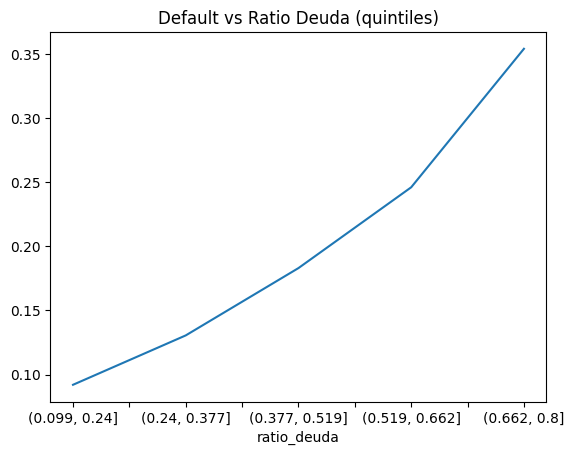

In [9]:
df.groupby(pd.qcut(df["ratio_deuda"], 5))["default_12m"].mean().plot()
plt.title("Default vs Ratio Deuda (quintiles)")
plt.show()

C:\Users\einfantesz\AppData\Local\Temp\ipykernel_28188\2149251018.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_edad = df.groupby("edad_bin")["default_12m"].mean()


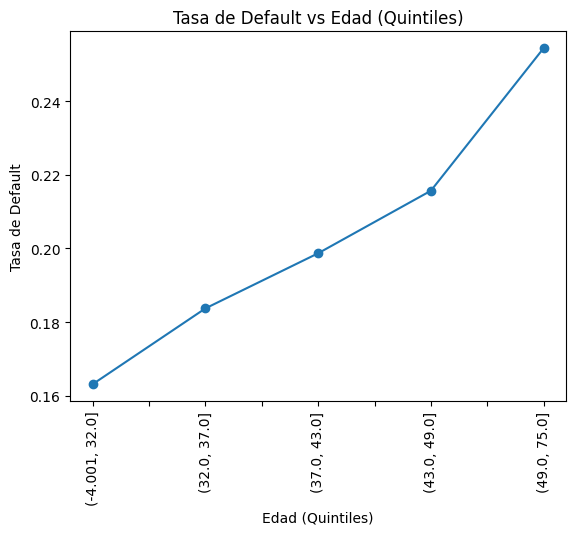

In [10]:
# Binning por quintiles de edad
df["edad_bin"] = pd.qcut(df["edad"], 5)

default_edad = df.groupby("edad_bin")["default_12m"].mean()

default_edad.plot(marker="o")
plt.title("Tasa de Default vs Edad (Quintiles)")
plt.xlabel("Edad (Quintiles)")
plt.ylabel("Tasa de Default")
plt.xticks(rotation=90)
plt.show()